### IMPORTACIÓN DE PAQUETES

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3MB 4.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=ef13952e54d366112e8a204a2c8353934e877915b22ebffc01dea75f7d6242be
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
import yfinance
import seaborn as sns
sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### DATA

In [ ]:
data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "1994-01-07", end = "2021-05-31", 
                              interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)
df = data.copy()

[*********************100%***********************]  4 of 4 completed


In [ ]:
df['spx'] = df['^GSPC'].Close[:]
df['dax'] = df['^GDAXI'].Close[:]
df['ftse'] = df['^FTSE'].Close[:]
df['nikkei'] = df['^N225'].Close[:]

In [ ]:
del df['^N225']
del df['^GSPC']
del df['^GDAXI']
del df['^FTSE']
df=df.asfreq('b')
df=df.fillna(method='ffill')

In [ ]:
df['market_value']=df.ftse

In [ ]:
df['ret_spx'] = df.spx.pct_change(1)*100
df['ret_ftse'] = df.ftse.pct_change(1)*100
df['ret_dax'] = df.dax.pct_change(1)*100
df['ret_nikkei'] = df.nikkei.pct_change(1)*100

In [ ]:
size = int(len(df)*0.8)
df_train, df_test = df.iloc[:size], df.iloc[size:]

In [ ]:
df_train.head

<bound method NDFrame.head of                     spx           dax  ...   ret_dax ret_nikkei
                                       ...                     
Date                                   ...                     
1994-01-07   469.899994   2224.949951  ...       NaN        NaN
1994-01-10   475.269989   2225.000000  ...  0.002249   1.762467
1994-01-11   474.130005   2228.100098  ...  0.139330   0.226696
1994-01-12   474.170013   2182.060059  ... -2.066336   1.669606
1994-01-13   472.470001   2142.370117  ... -1.818921  -1.152615
...                 ...           ...  ...       ...        ...
2015-12-01  2102.629883  11261.240234  ... -1.062975   1.341588
2015-12-02  2079.510010  11190.019531  ... -0.632441  -0.371118
2015-12-03  2049.620117  10789.240234  ... -3.581578   0.008875
2015-12-04  2091.689941  10752.099609  ... -0.344238  -2.183661
2015-12-07  2077.070068  10886.089844  ...  1.246177   0.992951

[5717 rows x 9 columns]>

### SARIMA (p,d,q)(P,D,Q,s)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
model = SARIMAX(df_train.ret_ftse[1:],order=(1,0,1),seasonal_order=(1,0,1,5))
results = model.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                          ret_ftse   No. Observations:                 5716
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 5)   Log Likelihood               -8847.203
Date:                           Mon, 07 Jun 2021   AIC                          17704.406
Time:                                   19:24:51   BIC                          17737.661
Sample:                               01-10-1994   HQIC                         17715.983
                                    - 12-07-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6996      0.068     10.304      0.000       0.566       0.833
ma.L1         -0.7447      0.063    -11.821      0.000      -0.868      -0.621
ar.S.L5        0.3087      0.164      1.882      0.060      -0.013       0.630
ma.S.L5       -0.3502      0.162     -2.164      0.030      -0.667      -0.033
sigma2         1.2940      0.012    104.771      0.000       1.270       1.318
===================================================================================
Ljung-Box (Q):                      127.11   Jarque-Bera (JB):              8678.05
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### PREDICCIÓN

In [ ]:
# Obtain predicted values
start=len(df_train)
end=len(df_train)+len(df_test)-1
predictions = results.predict(start=start, end=end+30).rename('Predictions')

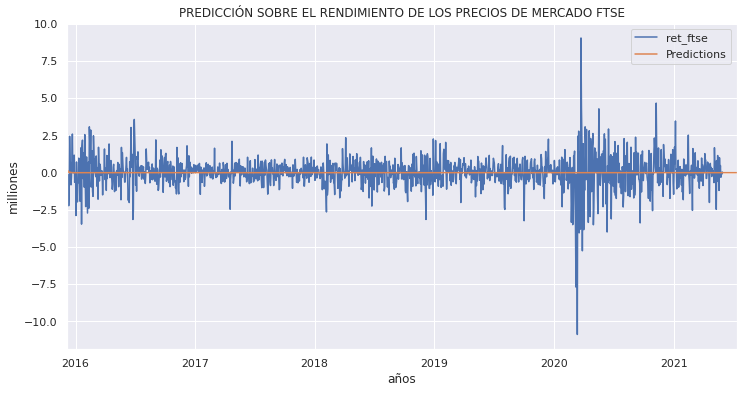

In [ ]:
# Plot predictions against known values
title ='PREDICCIÓN SOBRE EL RENDIMIENTO DE LOS PRECIOS DE MERCADO FTSE'
ylabel='milliones'
xlabel='años'

ax = df_test.ret_ftse.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### MODELO SARIMAX

In [ ]:
model2 = SARIMAX(df.market_value,exog=df.spx,order=(1,1,3),seasonal_order=(2,0,1,5))
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                      market_value   No. Observations:                 7147
Model:             SARIMAX(1, 1, 3)x(2, 0, 1, 5)   Log Likelihood              -38353.131
Date:                           Mon, 07 Jun 2021   AIC                          76724.263
Time:                                   18:25:01   BIC                          76786.132
Sample:                               01-07-1994   HQIC                         76745.560
                                    - 05-31-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            1.7640      0.016    111.619      0.000       1.733       1.795
ar.L1         -0.3516      0.147     -2.392      0.017      -0.640      -0.064
ma.L1          0.1678      0.146      1.153      0.249      -0.117       0.453
ma.L2         -0.1109      0.029     -3.774      0.000      -0.169      -0.053
ma.L3         -0.0678      0.010     -6.905      0.000      -0.087      -0.049
ar.S.L5        0.3754      0.323      1.164      0.245      -0.257       1.008
ar.S.L10      -0.0116      0.014     -0.807      0.419      -0.040       0.017
ma.S.L5       -0.4013      0.322     -1.246      0.213      -1.033       0.230
sigma2      2682.3833     27.652     97.006      0.000    2628.187    2736.579
===================================================================================
Ljung-Box (Q):                       63.66   Jarque-Bera (JB):              4037.89
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -0.34
Prob(H) (two-sided):                  0.10   Kurtosis:                         6.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""